<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# NLP & APIs : Predicting Positive & Negative sentiments on Ubisoft's reviews

--- 
# Part 2


---

### Contents:
- [Background & Problem Statement](#Background)
- [Import and Cleaning of Data](#Import_n_Clean)
- [Data Dictionary](#data_dict)
- [Modelling](#modelling)
- [Conclusions & Recommendations](#conc_rec)

---
<a id='Background'></a>

# Background & Problem Statement
---

[Ubisoft](https://www.ubisoft.com/en-us/company/about-us) is a leading company in the gaming industry. Some [popular games](https://www.thegamer.com/ubisoft-best-games/#assassin-rsquo-s-creed-4-black-flag) include the famous Assassin's Creed series, Far Cry, Tom Clancy, as well as Rayman, just to name a few. Ubisoft has been developing a new game over the past couple of years, called "Skull & Bones". This upcoming game was [inspired by their most popular Assassin's Creed series, "Assassin's Creed IV: Black Flag"](https://screenrant.com/skull-and-bones-best-game-recommendations/).

Posing as someone who is working for Ubisoft's data team, I am interested in identifying reviews for Assassin's Creed IV: Black Flag, and classifying whether they are positive or negative. This is so we can use this model in the future, to further analyse which part of the game people liked and disliked, so Ubisoft can further improve the game, as well as include and improve the appropriate elements for their upcoming Skull & Bones game. 

For now, <font color = 'green'>**the aim is to create a model that is able to perform sentiment analysis on Assassin's Creed IV: Black Flag steam reviews**</font>.

For this project in particular, I will be using Naive Bayes and Random Forest classifiers as the developing models to perform the sentiment analysis. Since the data that was retrieved from Steam does have a column on whether the user would or would not recommend the game, we will use that as a comparison on how well the model performed.

<a id='Import_n_Clean'></a>

## Import and Cleaning of Data

In [40]:
# Importing all libraries used: 

import requests
import pandas as pd 
import numpy as np
from datetime import datetime
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

Importing the data from Steam's Assassin's Creed IV: Black Flag reviews.

In [41]:
reviews = pd.read_csv('data/assassins_creed_reviews.csv')
pd.set_option('display.max_columns', None)
reviews.head()

,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china
0,76561198156016347,267,21,2856,0,2856.0,1518982944,85460916,english,The only game where i avoid fast travel.,1611779242,1611779242,True,3660,179,0.986510,11,True,False,False,False
1,76561198149047566,0,52,1838,0,1838.0,1593601946,76223418,english,This is the Best Assassins Creed game and Prob...,1600521179,1600521179,True,2499,38,0.978945,10,True,False,False,False
2,76561197990642312,0,2,116875,89,90196.0,1690346522,69682784,english,"Best game ever, iv'e been playing from day one...",1590260976,1590260976,True,2122,218,0.978677,0,True,False,False,False
3,76561198982554607,77,4,4719,0,4036.0,1617472093,88206852,english,Shanties Before Panties,1615404962,1615404962,True,2138,878,0.974192,11,True,False,False,False
4,76561198849119685,0,10,1592,0,1177.0,1644543449,71445029,english,Best part of the game are the sea shanties. Lo...,1593217346,1593217346,True,1021,235,0.958189,0,True,False,False,False


In [42]:
# Checking to see the non-recommended rows
reviews[reviews['voted_up']== False]

,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china
40,76561197972791211,0,1,9002,0,9002.0,1433899439,16284423,english,"The game was fun, until uPlay deleted a 150+ h...",1433899702,1433899702,False,1899,189,0.837447,54,True,False,False,False
41,76561198813287393,3292,87,3167,0,3167.0,1597974140,118620520,english,Ubisoft has started REMOVING single player gam...,1657531965,1657531965,False,69,1,0.835667,2,True,False,False,False
76,76561198138023004,0,6,462,0,443.0,1488562074,30490128,english,"Before I bought the game, I saw those negative...",1489410618,1489411122,False,385,25,0.795054,24,True,False,False,False
81,76561198020660448,0,37,3955,0,3926.0,1444090830,18285137,english,Years later and neither Steam nor Ubisoft care...,1443757471,1443757471,False,178,5,0.791920,2,True,False,False,False
100,76561198007976498,583,17,832,0,769.0,1496824437,16987654,english,>Click play on steam\n>uPlay opens\n>Uplay not...,1436594325,1436594325,False,808,117,0.761829,24,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21981,76561198039556186,0,5,3291,0,1716.0,1474784477,13753986,english,"Pretty good pirate game, terrible assassin gam...",1420094851,1420094851,False,0,0,0.000000,0,True,False,False,False
22007,76561198030042611,0,17,2016,0,57.0,1423328027,13685137,english,Now I see why people say UPlay sucks.\n\nIt re...,1419850080,1419850080,False,0,0,0.000000,0,True,False,False,False
22011,76561198033285853,0,3,8105,0,3438.0,1570397078,13677623,english,THIS GAME IS GREAT WHEN IT DOESN'T CRASH....DO...,1419813337,1419813337,False,0,0,0.000000,0,True,False,False,False
22027,76561198148735922,193,11,322,0,156.0,1584616515,13637833,english,it is not lauching and my comp can hold anythink,1419690702,1419690702,False,0,0,0.000000,0,True,False,False,False


In [43]:
# Checking the type of each column
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22056 entries, 0 to 22055
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   steamid                      22056 non-null  int64  
 1   num_games_owned              22056 non-null  int64  
 2   num_reviews                  22056 non-null  int64  
 3   playtime_forever             22056 non-null  int64  
 4   playtime_last_two_weeks      22056 non-null  int64  
 5   playtime_at_review           22028 non-null  float64
 6   last_played                  22056 non-null  int64  
 7   recommendationid             22056 non-null  int64  
 8   language                     22056 non-null  object 
 9   review                       21975 non-null  object 
 10  timestamp_created            22056 non-null  int64  
 11  timestamp_updated            22056 non-null  int64  
 12  voted_up                     22056 non-null  bool   
 13  votes_up        

In [44]:
# Checking for null values
reviews.isnull().sum()

steamid                         0
num_games_owned                 0
num_reviews                     0
playtime_forever                0
playtime_last_two_weeks         0
playtime_at_review             28
last_played                     0
recommendationid                0
language                        0
review                         81
timestamp_created               0
timestamp_updated               0
voted_up                        0
votes_up                        0
votes_funny                     0
weighted_vote_score             0
comment_count                   0
steam_purchase                  0
received_for_free               0
written_during_early_access     0
hidden_in_steam_china           0
dtype: int64

Considering the number of null values are very small, and the fact that null values are present in the 'review' column, we will drop the rows with null values, as the reviews are the basis for our sentiment analysis.

In [45]:
reviews.dropna(inplace= True)
reviews.isnull().sum()

steamid                        0
num_games_owned                0
num_reviews                    0
playtime_forever               0
playtime_last_two_weeks        0
playtime_at_review             0
last_played                    0
recommendationid               0
language                       0
review                         0
timestamp_created              0
timestamp_updated              0
voted_up                       0
votes_up                       0
votes_funny                    0
weighted_vote_score            0
comment_count                  0
steam_purchase                 0
received_for_free              0
written_during_early_access    0
hidden_in_steam_china          0
dtype: int64

In [46]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21947 entries, 0 to 22055
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   steamid                      21947 non-null  int64  
 1   num_games_owned              21947 non-null  int64  
 2   num_reviews                  21947 non-null  int64  
 3   playtime_forever             21947 non-null  int64  
 4   playtime_last_two_weeks      21947 non-null  int64  
 5   playtime_at_review           21947 non-null  float64
 6   last_played                  21947 non-null  int64  
 7   recommendationid             21947 non-null  int64  
 8   language                     21947 non-null  object 
 9   review                       21947 non-null  object 
 10  timestamp_created            21947 non-null  int64  
 11  timestamp_updated            21947 non-null  int64  
 12  voted_up                     21947 non-null  bool   
 13  votes_up        

Going through each column to see which is relevant for the necessary analysis:

The last few columns 'steam_purchase', 'received_for_free', 'written_during_early_access', and 'hidden_in_steam_china' do not contribute much for the analysis portion. Let's drop these columns.

In [47]:
reviews.drop(['steam_purchase', 'received_for_free', 'written_during_early_access', 'hidden_in_steam_china'], axis = 1, inplace= True)
reviews.head()

,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count
0,76561198156016347,267,21,2856,0,2856.0,1518982944,85460916,english,The only game where i avoid fast travel.,1611779242,1611779242,True,3660,179,0.986510,11
1,76561198149047566,0,52,1838,0,1838.0,1593601946,76223418,english,This is the Best Assassins Creed game and Prob...,1600521179,1600521179,True,2499,38,0.978945,10
2,76561197990642312,0,2,116875,89,90196.0,1690346522,69682784,english,"Best game ever, iv'e been playing from day one...",1590260976,1590260976,True,2122,218,0.978677,0
3,76561198982554607,77,4,4719,0,4036.0,1617472093,88206852,english,Shanties Before Panties,1615404962,1615404962,True,2138,878,0.974192,11
4,76561198849119685,0,10,1592,0,1177.0,1644543449,71445029,english,Best part of the game are the sea shanties. Lo...,1593217346,1593217346,True,1021,235,0.958189,0


Notice that the timestamp format for 'timestamp_created' and 'timestamp_updated' are in a different format. Looking through the Steam documentation, we realise this is in unix format. Let's change this to datetime.

In [48]:
reviews['timestamp_created'] = pd.to_datetime(reviews['timestamp_created'], unit='s')
reviews['timestamp_updated'] = pd.to_datetime(reviews['timestamp_updated'], unit='s')
reviews['last_played'] = pd.to_datetime(reviews['last_played'], unit='s')
reviews.head()

,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count
0,76561198156016347,267,21,2856,0,2856.0,2018-02-18 19:42:24,85460916,english,The only game where i avoid fast travel.,2021-01-27 20:27:22,2021-01-27 20:27:22,True,3660,179,0.986510,11
1,76561198149047566,0,52,1838,0,1838.0,2020-07-01 11:12:26,76223418,english,This is the Best Assassins Creed game and Prob...,2020-09-19 13:12:59,2020-09-19 13:12:59,True,2499,38,0.978945,10
2,76561197990642312,0,2,116875,89,90196.0,2023-07-26 04:42:02,69682784,english,"Best game ever, iv'e been playing from day one...",2020-05-23 19:09:36,2020-05-23 19:09:36,True,2122,218,0.978677,0
3,76561198982554607,77,4,4719,0,4036.0,2021-04-03 17:48:13,88206852,english,Shanties Before Panties,2021-03-10 19:36:02,2021-03-10 19:36:02,True,2138,878,0.974192,11
4,76561198849119685,0,10,1592,0,1177.0,2022-02-11 01:37:29,71445029,english,Best part of the game are the sea shanties. Lo...,2020-06-27 00:22:26,2020-06-27 00:22:26,True,1021,235,0.958189,0


We're wondering what the difference is between the timestamp created and timestamp updated. If there is not much difference, we can drop one of these columns.

In [49]:
print(reviews.shape)
reviews[reviews['timestamp_created'] == reviews['timestamp_updated']].shape

(21947, 17)


(19342, 17)

There are less than 2,000 rows where the timestamps differ. As such, it would not be as beneficial for the analysis portion. Let's drop one of these columns.

In [50]:
reviews.drop(columns = 'timestamp_updated', inplace= True)
reviews.head()

,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,recommendationid,language,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count
0,76561198156016347,267,21,2856,0,2856.0,2018-02-18 19:42:24,85460916,english,The only game where i avoid fast travel.,2021-01-27 20:27:22,True,3660,179,0.986510,11
1,76561198149047566,0,52,1838,0,1838.0,2020-07-01 11:12:26,76223418,english,This is the Best Assassins Creed game and Prob...,2020-09-19 13:12:59,True,2499,38,0.978945,10
2,76561197990642312,0,2,116875,89,90196.0,2023-07-26 04:42:02,69682784,english,"Best game ever, iv'e been playing from day one...",2020-05-23 19:09:36,True,2122,218,0.978677,0
3,76561198982554607,77,4,4719,0,4036.0,2021-04-03 17:48:13,88206852,english,Shanties Before Panties,2021-03-10 19:36:02,True,2138,878,0.974192,11
4,76561198849119685,0,10,1592,0,1177.0,2022-02-11 01:37:29,71445029,english,Best part of the game are the sea shanties. Lo...,2020-06-27 00:22:26,True,1021,235,0.958189,0


Let's take a look at whether one user made multiple reviews or if there was only 1 review.

In [51]:
print(reviews.shape)
print(len(reviews['steamid'].unique()))

(21947, 16)
21947


It seems like all reviews are from unique users. This means the reviews given should be genuinely what each user feels, with no bias of 1 user making multiple similar reviews. Since this is the case, the userid and recommendationid is now not needed, and we can drop these.

In [52]:
reviews.drop(columns= ['steamid', 'recommendationid'], inplace= True)
reviews.head()

,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,language,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count
0,267,21,2856,0,2856.0,2018-02-18 19:42:24,english,The only game where i avoid fast travel.,2021-01-27 20:27:22,True,3660,179,0.986510,11
1,0,52,1838,0,1838.0,2020-07-01 11:12:26,english,This is the Best Assassins Creed game and Prob...,2020-09-19 13:12:59,True,2499,38,0.978945,10
2,0,2,116875,89,90196.0,2023-07-26 04:42:02,english,"Best game ever, iv'e been playing from day one...",2020-05-23 19:09:36,True,2122,218,0.978677,0
3,77,4,4719,0,4036.0,2021-04-03 17:48:13,english,Shanties Before Panties,2021-03-10 19:36:02,True,2138,878,0.974192,11
4,0,10,1592,0,1177.0,2022-02-11 01:37:29,english,Best part of the game are the sea shanties. Lo...,2020-06-27 00:22:26,True,1021,235,0.958189,0


There are also a decent number of repetitive columns refering to the playtime. Perhaps the only column we would be interested in analysing would be the playtime at review. Let's drop the other two columns.

In [53]:
reviews.drop(columns= ['playtime_forever', 'playtime_last_two_weeks'], inplace= True)
reviews.head()

,num_games_owned,num_reviews,playtime_at_review,last_played,language,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count
0,267,21,2856.0,2018-02-18 19:42:24,english,The only game where i avoid fast travel.,2021-01-27 20:27:22,True,3660,179,0.986510,11
1,0,52,1838.0,2020-07-01 11:12:26,english,This is the Best Assassins Creed game and Prob...,2020-09-19 13:12:59,True,2499,38,0.978945,10
2,0,2,90196.0,2023-07-26 04:42:02,english,"Best game ever, iv'e been playing from day one...",2020-05-23 19:09:36,True,2122,218,0.978677,0
3,77,4,4036.0,2021-04-03 17:48:13,english,Shanties Before Panties,2021-03-10 19:36:02,True,2138,878,0.974192,11
4,0,10,1177.0,2022-02-11 01:37:29,english,Best part of the game are the sea shanties. Lo...,2020-06-27 00:22:26,True,1021,235,0.958189,0


The 'voted_up' column, referring to recommended or not, is in boolean format. However, we'd like to see this in integer values of 1 and 0. Let's convert this datatype.

In [54]:
reviews['voted_up'] = reviews['voted_up'].astype(int)

By right, when we scraped our data from Steam, we only scraped the data labelled as 'english'. Let's double check that 'english' is the only value in this column.

In [55]:
reviews['language'].unique()

array(['english'], dtype=object)

'english' is the sole value in the column. As such, we can drop this column.

In [56]:
reviews.drop(columns = 'language', inplace = True)
reviews.head()

,num_games_owned,num_reviews,playtime_at_review,last_played,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count
0,267,21,2856.0,2018-02-18 19:42:24,The only game where i avoid fast travel.,2021-01-27 20:27:22,1,3660,179,0.986510,11
1,0,52,1838.0,2020-07-01 11:12:26,This is the Best Assassins Creed game and Prob...,2020-09-19 13:12:59,1,2499,38,0.978945,10
2,0,2,90196.0,2023-07-26 04:42:02,"Best game ever, iv'e been playing from day one...",2020-05-23 19:09:36,1,2122,218,0.978677,0
3,77,4,4036.0,2021-04-03 17:48:13,Shanties Before Panties,2021-03-10 19:36:02,1,2138,878,0.974192,11
4,0,10,1177.0,2022-02-11 01:37:29,Best part of the game are the sea shanties. Lo...,2020-06-27 00:22:26,1,1021,235,0.958189,0


In [96]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21947 entries, 0 to 22055
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   num_games_owned      21947 non-null  int64         
 1   num_reviews          21947 non-null  int64         
 2   playtime_at_review   21947 non-null  float64       
 3   last_played          21947 non-null  datetime64[ns]
 4   review               21947 non-null  object        
 5   timestamp_created    21947 non-null  datetime64[ns]
 6   voted_up             21947 non-null  int64         
 7   votes_up             21947 non-null  int64         
 8   votes_funny          21947 non-null  int64         
 9   weighted_vote_score  21947 non-null  float64       
 10  comment_count        21947 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(6), object(1)
memory usage: 2.0+ MB


<a id='data_dict'></a>

---

# Data Dictionary

----

|Feature|Type|Description|
|---|---|---|
|num_games_owned|int|number of games owned by the user|
|num_reviews|int|number of reviews returned in this response|
|playtime_at_review|float|playtime when the review was written|
|last_played|datetime|time for when the user last played|
|review|object|text of written review|
|timestamp_created|datetime|date the review was created|
|voted_up|int|1 means it was a positive recommendation|
|votes_up|int|the number of users that found this review helpful|
|votes_funny|int|the number of users that found this review funny|
|weighted_vote_score|float|helpfulness score|
|comment_count|int|number of comments posted on this review|

---
# Exploratory Data Analysis
---

## Distribution of data

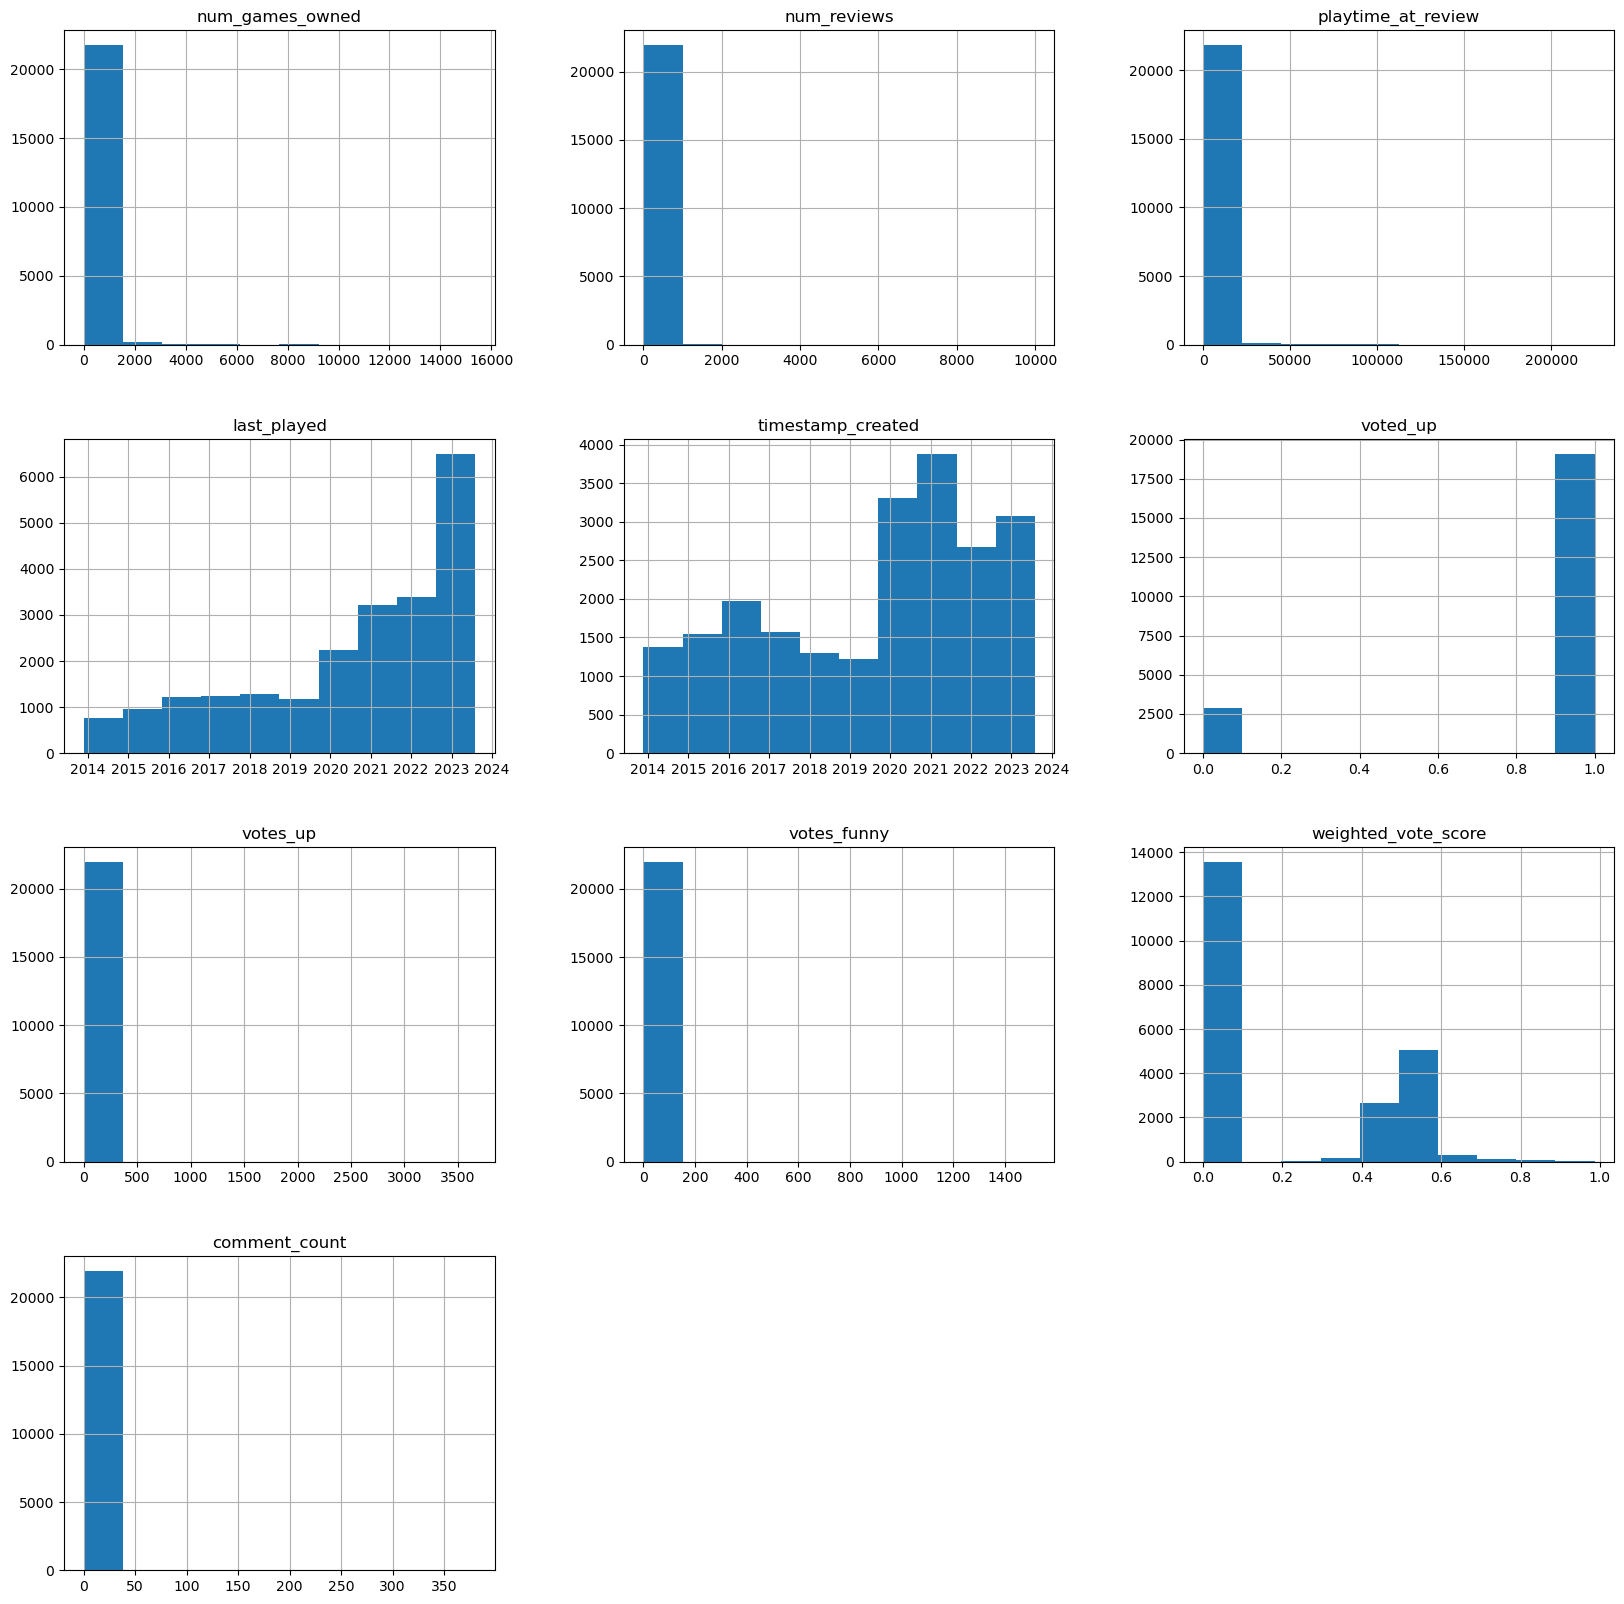

In [57]:
reviews.hist(figsize=(20, 20));

Taking a closer look at the distribution of each column, we can see the majority of the data for votes, comment, as well asnumber of games owned and reviews given, all fell within the lower portion of the histogram. 

This gives us a good idea of the general idea of the numbers ranging for the reviews.

Now, let's look at the pairplots to see the relationships between each.

### Correlation of Features

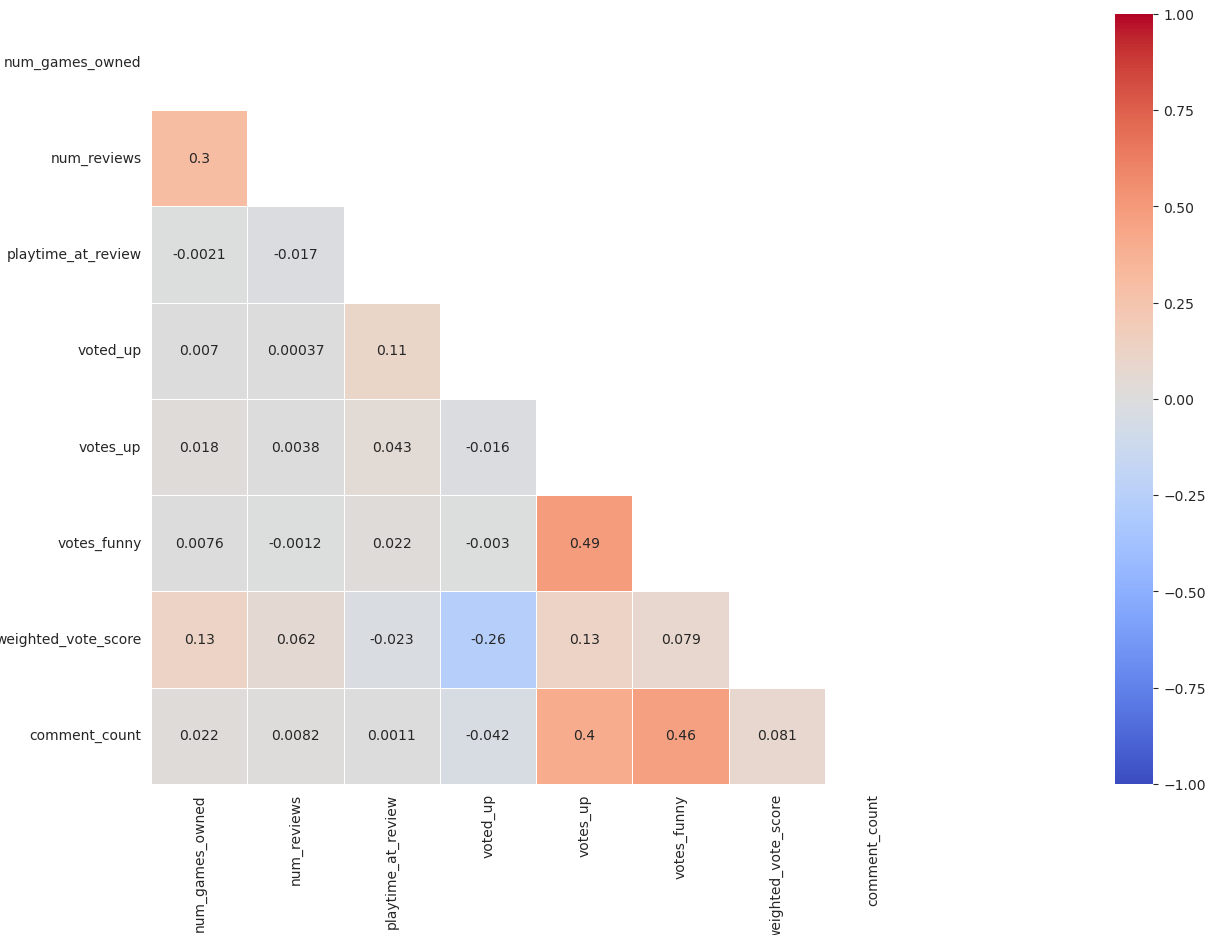

In [39]:
plt.figure(figsize = (50,10))

corr = reviews.corr(numeric_only=True)

corr_mask = np.zeros_like(corr)
corr_mask[np.triu_indices_from(corr_mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = corr_mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap= 'coolwarm')

From the heatmap, we can see stronger correlations between number of reviews and number of games owned, votes up/funny votes and comments, as well as voted up receommendation with weighted score. 

Let's take a closer look at the pairplots.

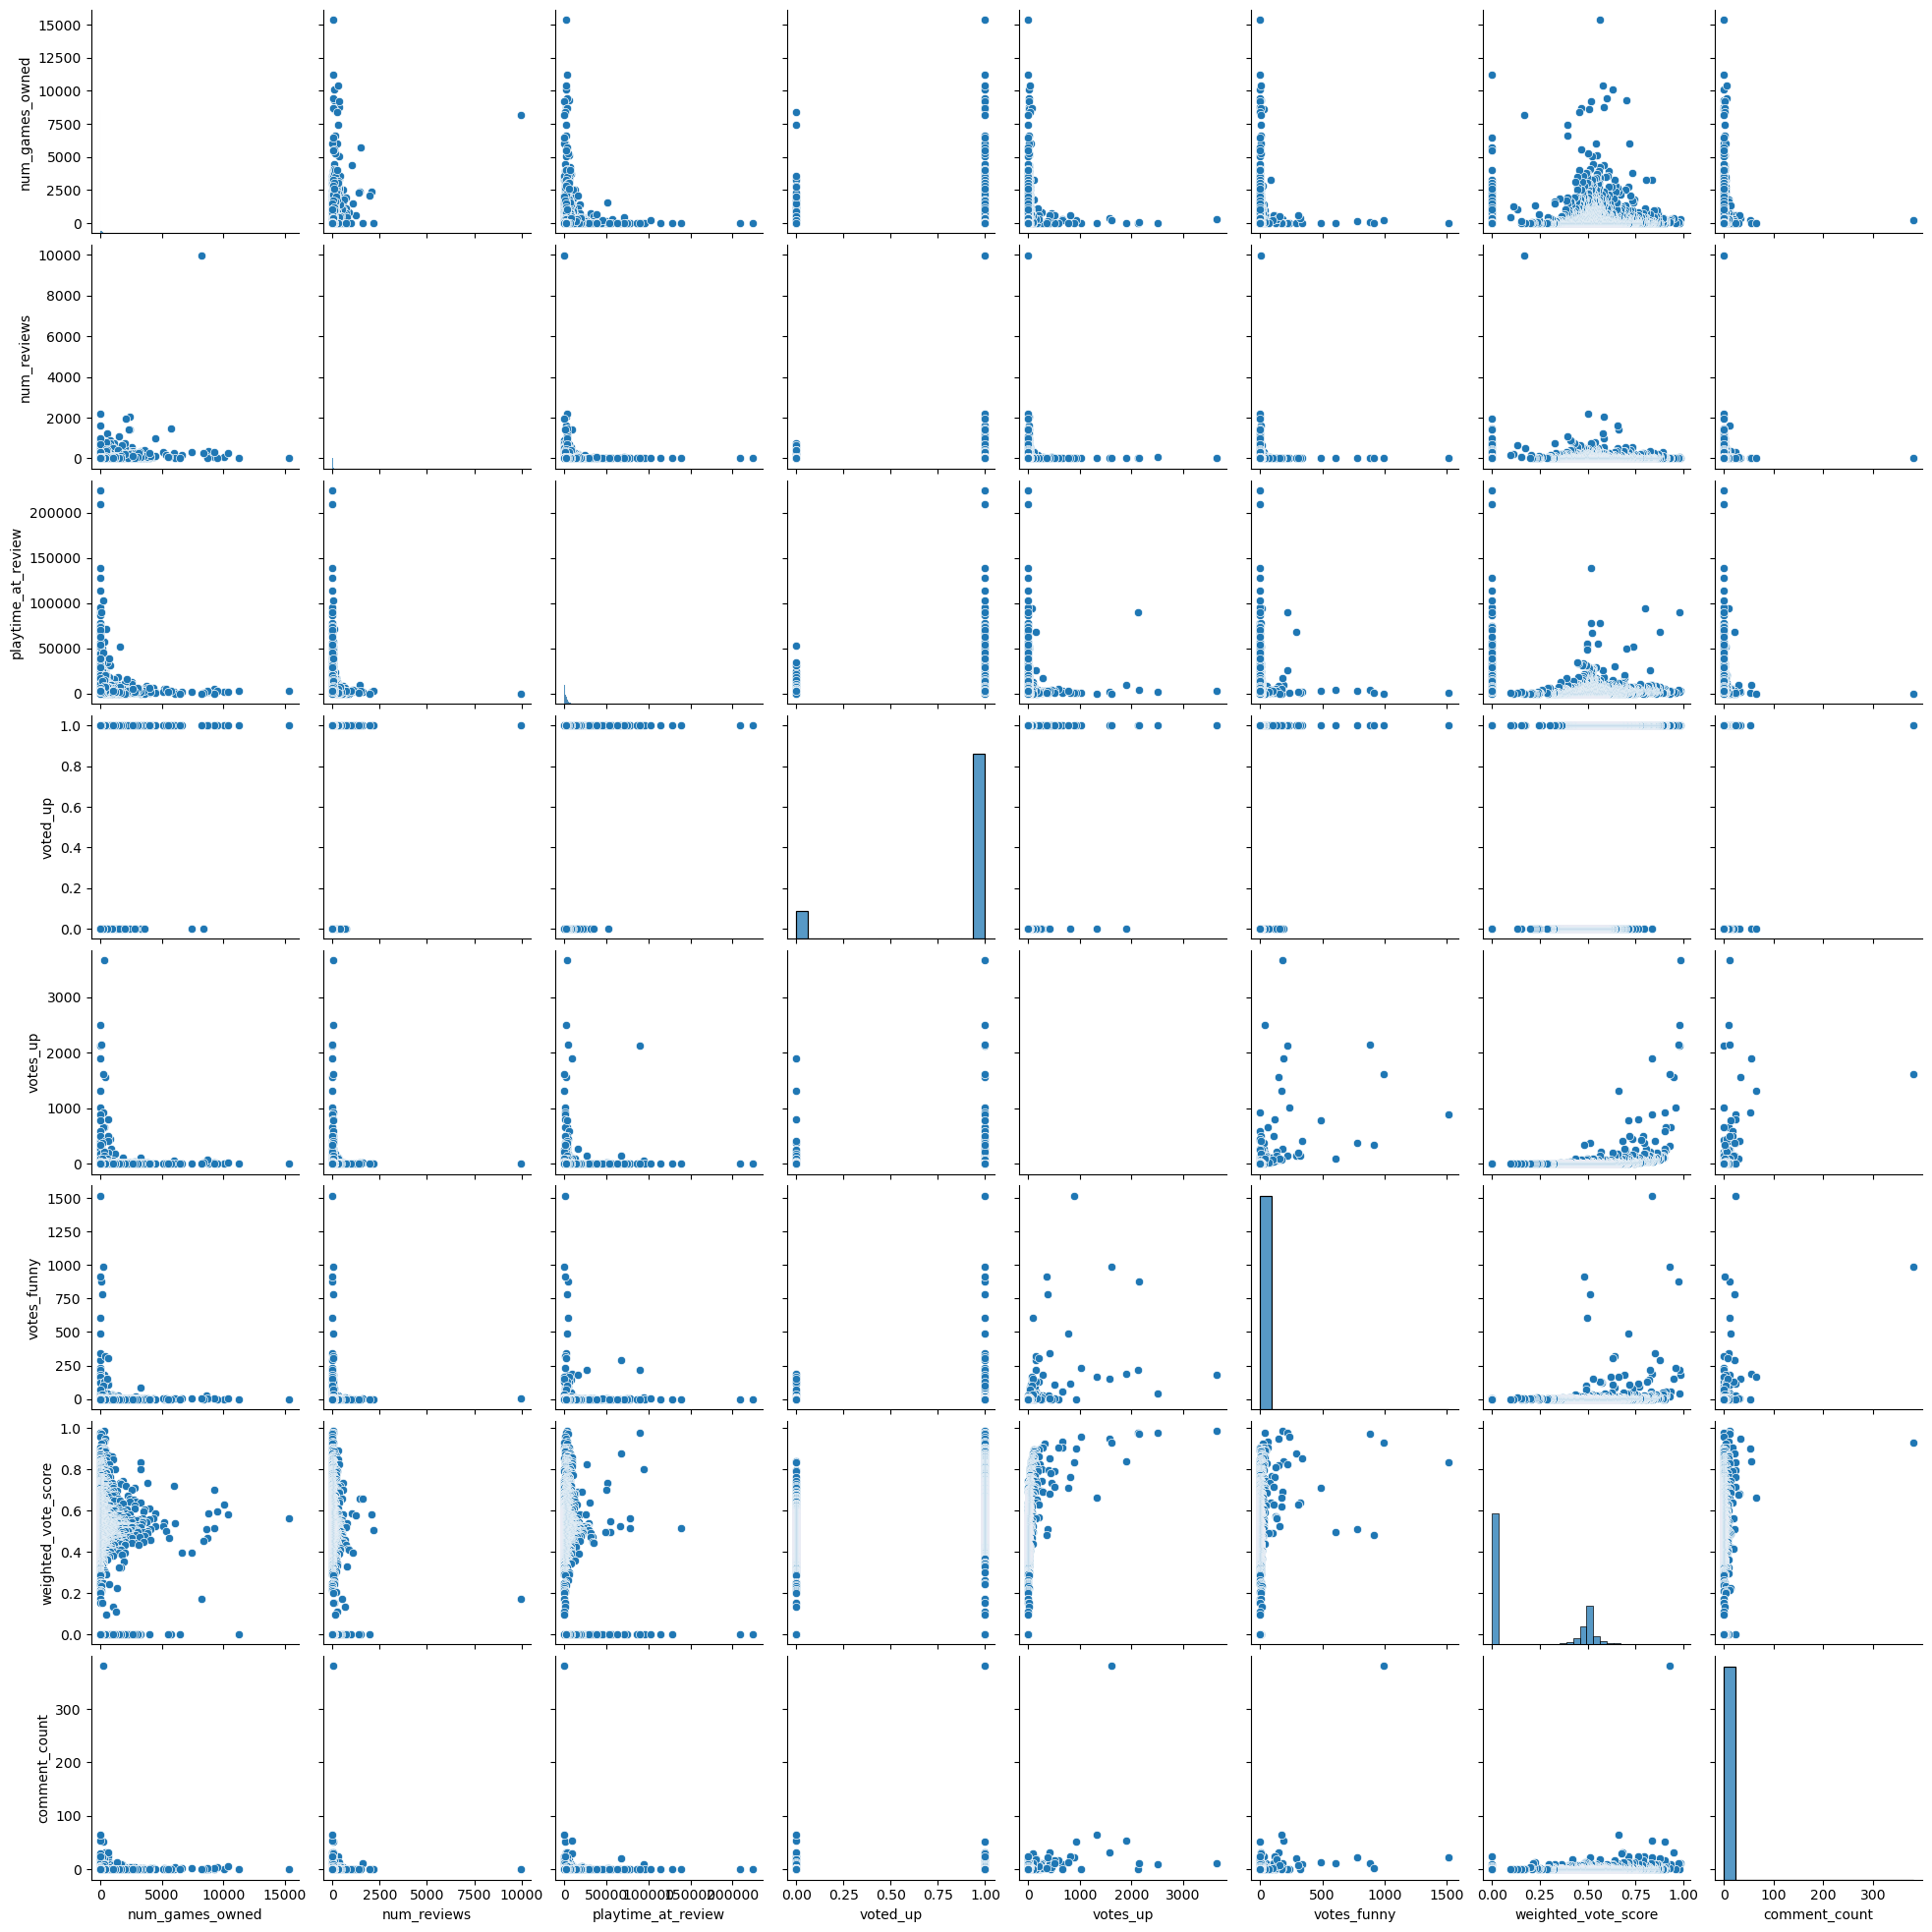

In [58]:
sns.pairplot(reviews);

Looking at the pairplot, we can see in more detail how some features are correlated to each other. For example, the weighted votes score seems heavily reliant on number of games one owns, as well as the number of votes up the reviews get.

## Word Analysis

Let's take a closer look into the words being used in the reviews. To do this, we are going to extract 50 random comments to go through the appropriate cleaning process.

In [59]:
# Selecting random 50 reviews to see what are some common stop words.

sample = list(reviews['review'].sample(n = 50, axis = 0, random_state = 123))
sample

["Very enjoyable for the first 20-30 hours. Great gameplay, good mix between stealth and action, and the ships and larger map comes along just at the right time, as you're getting bored of the linear storyline. But then, well, it kinda fizzled out for me and became too grindy. But well worth playing for those initial 20-30 hours, fantastic.",
 'Shittiest performance ever.',
 'still my fav and still sad about Blackbeard',
 'pirate game have sword pretty cool',
 'Run around mass murdering people.\n\nSail around mass murdering small ships.',
 "Assasins and pirates , never thought that would be a good combination... \nIt's a fucking amazing combination",
 'haha pirate',
 "As of right now, this moment. This is my favorite game. I am on my second playthrough as my first version was...ahem different. This game is a masterpiece, easily the best in the AC series. Who would have known in AC1 one that Altair's climbing, parkour, and wrist knives would eventually evolve into the ULTIMATE pirate ga

In [63]:
# Tokenizing the sentences.
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [64]:
sample_token = [tokenizer.tokenize(sample[i].lower()) for i in range(len(sample))]
sample_token

[['very',
  'enjoyable',
  'for',
  'the',
  'first',
  '20',
  '-30',
  'hours',
  '.',
  'great',
  'gameplay',
  ',',
  'good',
  'mix',
  'between',
  'stealth',
  'and',
  'action',
  ',',
  'and',
  'the',
  'ships',
  'and',
  'larger',
  'map',
  'comes',
  'along',
  'just',
  'at',
  'the',
  'right',
  'time',
  ',',
  'as',
  'you',
  "'re",
  'getting',
  'bored',
  'of',
  'the',
  'linear',
  'storyline',
  '.',
  'but',
  'then',
  ',',
  'well',
  ',',
  'it',
  'kinda',
  'fizzled',
  'out',
  'for',
  'me',
  'and',
  'became',
  'too',
  'grindy',
  '.',
  'but',
  'well',
  'worth',
  'playing',
  'for',
  'those',
  'initial',
  '20',
  '-30',
  'hours',
  ',',
  'fantastic',
  '.'],
 ['shittiest', 'performance', 'ever', '.'],
 ['still', 'my', 'fav', 'and', 'still', 'sad', 'about', 'blackbeard'],
 ['pirate', 'game', 'have', 'sword', 'pretty', 'cool'],
 ['run',
  'around',
  'mass',
  'murdering',
  'people',
  '.',
  'sail',
  'around',
  'mass',
  'murdering',
  

In [65]:
# Defining a function to remove punctuations from the tokenized words
def remove_punc(list):
    clean_list = []
    for sublist in list:
        clean_words = [word.strip(',.!') for word in sublist if word not in [',', '.', '...', '!']]
        clean_list.append(clean_words)
    return clean_list

In [66]:
sample_token = remove_punc(sample_token)
sample_token

[['very',
  'enjoyable',
  'for',
  'the',
  'first',
  '20',
  '-30',
  'hours',
  'great',
  'gameplay',
  'good',
  'mix',
  'between',
  'stealth',
  'and',
  'action',
  'and',
  'the',
  'ships',
  'and',
  'larger',
  'map',
  'comes',
  'along',
  'just',
  'at',
  'the',
  'right',
  'time',
  'as',
  'you',
  "'re",
  'getting',
  'bored',
  'of',
  'the',
  'linear',
  'storyline',
  'but',
  'then',
  'well',
  'it',
  'kinda',
  'fizzled',
  'out',
  'for',
  'me',
  'and',
  'became',
  'too',
  'grindy',
  'but',
  'well',
  'worth',
  'playing',
  'for',
  'those',
  'initial',
  '20',
  '-30',
  'hours',
  'fantastic'],
 ['shittiest', 'performance', 'ever'],
 ['still', 'my', 'fav', 'and', 'still', 'sad', 'about', 'blackbeard'],
 ['pirate', 'game', 'have', 'sword', 'pretty', 'cool'],
 ['run',
  'around',
  'mass',
  'murdering',
  'people',
  'sail',
  'around',
  'mass',
  'murdering',
  'small',
  'ships'],
 ['assasins',
  'and',
  'pirates',
  'never',
  'thought',
 

Let's check out the stopwords in the library. We would like to tweak some of these words and add and remove some words.

In [72]:
stopword = stopwords.words('english')

stopword

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Looking at the reviews in the 50 samples, we would like to include some more stopwords into the initial library.

In [73]:
stopword.append(['really', 'spoiler', 'it', 'my', 'will', 'this', 'is', 'of', 'but', 'was', 'in', 'for'])
stopword

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

There are also many words we would like to remove, as we will want to analyse negative comments. For now, we will decide to remove the following stopwords.

In [74]:
remove = ['against', 'between', 'into', 'through', 'during', 'before', 'after',
 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
 'further', 'then', 'once', 'here','why', 'when', 'where', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
 "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [75]:
# Removing words from stopwords
print(len(stopword)) #length of stopwords before removal
for x in remove:
    stopword.remove(x)

print(len(stopword)) #length of stopwords after removal.

180
80


In [76]:
# Removing stop words from the sample reviews
sample_no_stop = []
for i in range(len(sample_token)):

    row = []
    for sample in sample_token[i]:
        if sample not in stopword:
            row.append(sample)

    sample_no_stop.append(row)

sample_no_stop

[['very',
  'enjoyable',
  'first',
  '20',
  '-30',
  'hours',
  'great',
  'gameplay',
  'good',
  'mix',
  'between',
  'stealth',
  'action',
  'ships',
  'larger',
  'map',
  'comes',
  'along',
  'just',
  'right',
  'time',
  "'re",
  'getting',
  'bored',
  'linear',
  'storyline',
  'then',
  'well',
  'kinda',
  'fizzled',
  'out',
  'became',
  'too',
  'grindy',
  'well',
  'worth',
  'playing',
  'initial',
  '20',
  '-30',
  'hours',
  'fantastic'],
 ['shittiest', 'performance', 'ever'],
 ['still', 'fav', 'still', 'sad', 'blackbeard'],
 ['pirate', 'game', 'sword', 'pretty', 'cool'],
 ['run',
  'around',
  'mass',
  'murdering',
  'people',
  'sail',
  'around',
  'mass',
  'murdering',
  'small',
  'ships'],
 ['assasins',
  'pirates',
  'never',
  'thought',
  'would',
  'good',
  'combination',
  "'s",
  'fucking',
  'amazing',
  'combination'],
 ['haha', 'pirate'],
 ['right',
  'now',
  'moment',
  'favorite',
  'game',
  'on',
  'second',
  'playthrough',
  'first',
  

Next, we will want to stem these words.

In [77]:
pstem = PorterStemmer()

In [78]:
# Stemming all words in the sample reviews.
sample_stemmed = []
for i in range(len(sample_no_stop)):

    row = []
    for sample in sample_no_stop[i]:
        row.append(pstem.stem(sample))

    sample_stemmed.append(row)

sample_stemmed

[['veri',
  'enjoy',
  'first',
  '20',
  '-30',
  'hour',
  'great',
  'gameplay',
  'good',
  'mix',
  'between',
  'stealth',
  'action',
  'ship',
  'larger',
  'map',
  'come',
  'along',
  'just',
  'right',
  'time',
  "'re",
  'get',
  'bore',
  'linear',
  'storylin',
  'then',
  'well',
  'kinda',
  'fizzl',
  'out',
  'becam',
  'too',
  'grindi',
  'well',
  'worth',
  'play',
  'initi',
  '20',
  '-30',
  'hour',
  'fantast'],
 ['shittiest', 'perform', 'ever'],
 ['still', 'fav', 'still', 'sad', 'blackbeard'],
 ['pirat', 'game', 'sword', 'pretti', 'cool'],
 ['run',
  'around',
  'mass',
  'murder',
  'peopl',
  'sail',
  'around',
  'mass',
  'murder',
  'small',
  'ship'],
 ['assasin',
  'pirat',
  'never',
  'thought',
  'would',
  'good',
  'combin',
  "'s",
  'fuck',
  'amaz',
  'combin'],
 ['haha', 'pirat'],
 ['right',
  'now',
  'moment',
  'favorit',
  'game',
  'on',
  'second',
  'playthrough',
  'first',
  'version',
  'ahem',
  'differ',
  'game',
  'masterpiec',

There are still numbers present in the review sample words. Let's remove these.

In [79]:
# Removing numbers from sample reviews
sample_no_num = []

for i in range(len(sample_stemmed)):

    row = []
    for sample in sample_stemmed[i]:
        if re.match(r'^[a-zA-Z]+$', sample):
            row.append(sample)

    sample_no_num.append(row)

sample_no_num

[['veri',
  'enjoy',
  'first',
  'hour',
  'great',
  'gameplay',
  'good',
  'mix',
  'between',
  'stealth',
  'action',
  'ship',
  'larger',
  'map',
  'come',
  'along',
  'just',
  'right',
  'time',
  'get',
  'bore',
  'linear',
  'storylin',
  'then',
  'well',
  'kinda',
  'fizzl',
  'out',
  'becam',
  'too',
  'grindi',
  'well',
  'worth',
  'play',
  'initi',
  'hour',
  'fantast'],
 ['shittiest', 'perform', 'ever'],
 ['still', 'fav', 'still', 'sad', 'blackbeard'],
 ['pirat', 'game', 'sword', 'pretti', 'cool'],
 ['run',
  'around',
  'mass',
  'murder',
  'peopl',
  'sail',
  'around',
  'mass',
  'murder',
  'small',
  'ship'],
 ['assasin',
  'pirat',
  'never',
  'thought',
  'would',
  'good',
  'combin',
  'fuck',
  'amaz',
  'combin'],
 ['haha', 'pirat'],
 ['right',
  'now',
  'moment',
  'favorit',
  'game',
  'on',
  'second',
  'playthrough',
  'first',
  'version',
  'ahem',
  'differ',
  'game',
  'masterpiec',
  'easili',
  'best',
  'in',
  'ac',
  'seri',
  

In [83]:
# Joining the reviews back into a whole sentences
sample_joined = []
for i in range(len(sample_no_num)):
    
    sample_joined.append(" ".join(sample_no_num[i]))


In [84]:
sample_joined

['veri enjoy first hour great gameplay good mix between stealth action ship larger map come along just right time get bore linear storylin then well kinda fizzl out becam too grindi well worth play initi hour fantast',
 'shittiest perform ever',
 'still fav still sad blackbeard',
 'pirat game sword pretti cool',
 'run around mass murder peopl sail around mass murder small ship',
 'assasin pirat never thought would good combin fuck amaz combin',
 'haha pirat',
 'right now moment favorit game on second playthrough first version ahem differ game masterpiec easili best in ac seri would known in one altair climb parkour wrist knive would eventu evolv into ultim pirat game alway want to pirat game let live out fantasi want more pirat adventur like on facebook said game year now go to say one best game ever play',
 'romant stori not pirat man betray friendship love hate honor suffer d action stori graphic soundtrack gameplay origin atmospher awesom just imao',
 'game reali good',
 'game on xb

After going through the samples, we want to go through the same process for all the reviews. Let's make this into a function to make it easier.

In [85]:
def stop_stem(df, df_column, stopwords):
    series = list(df[df_column].astype(str))
    token = [tokenizer.tokenize(series[i].lower()) for i in range(len(series))]
    
    no_stop = []
    for i in range(len(token)):

        row = []
        for sample in token[i]:
            if sample.lower() not in stopwords:
                row.append(sample.lower())

        no_stop.append(row)

    stemmed = []
    for i in range(len(no_stop)):
    
        row = []
        for sample in no_stop[i]:
            row.append(pstem.stem(sample))
    
        stemmed.append(row)

    stemmed = remove_punc(stemmed)

    no_num = []
    for i in range(len(stemmed)):
    
        row = []
        for sample in stemmed[i]:
            if re.match(r'^[a-zA-Z]+$', sample):
                row.append(sample)
    
        no_num.append(row)
        
    joined = []
    for i in range(len(no_num)):
        
        joined.append(" ".join(no_num[i]))

    df[df_column] = joined
    
    return df

In [86]:
clean_reviews = stop_stem(reviews, 'review', stopword)

In [87]:
clean_reviews

,num_games_owned,num_reviews,playtime_at_review,last_played,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count
0,267,21,2856.0,2018-02-18 19:42:24,onli game where avoid fast travel,2021-01-27 20:27:22,1,3660,179,0.986510,11
1,0,52,1838.0,2020-07-01 11:12:26,best assassin creed game probabl best pirat ga...,2020-09-19 13:12:59,1,2499,38,0.978945,10
2,0,2,90196.0,2023-07-26 04:42:02,best game ever iv play from day one year young...,2020-05-23 19:09:36,1,2122,218,0.978677,0
3,77,4,4036.0,2021-04-03 17:48:13,shanti befor panti,2021-03-10 19:36:02,1,2138,878,0.974192,11
4,0,10,1177.0,2022-02-11 01:37:29,best part game sea shanti lowkey jam poppin,2020-06-27 00:22:26,1,1021,235,0.958189,0
...,...,...,...,...,...,...,...,...,...,...,...
22051,0,4,4344.0,2016-03-23 21:03:09,although sometim some annoy bug game veri addict,2014-12-25 17:42:24,1,0,0,0.000000,0
22052,0,13,1944.0,2018-02-13 12:35:11,awesom game nice gameplay nice stori charact e...,2014-12-25 15:49:38,1,0,0,0.000000,0
22053,0,2,3292.0,2018-06-06 21:03:08,geez iunno stori such imagin illeg immigr on b...,2014-12-25 14:47:12,1,0,0,0.000000,0
22054,35,6,2316.0,2022-09-04 15:54:57,best ac game evah would buy ship,2014-12-25 12:39:02,1,0,0,0.000000,0


### Word Cloud of popular words

Viewing these as a word cloud to see the most common words

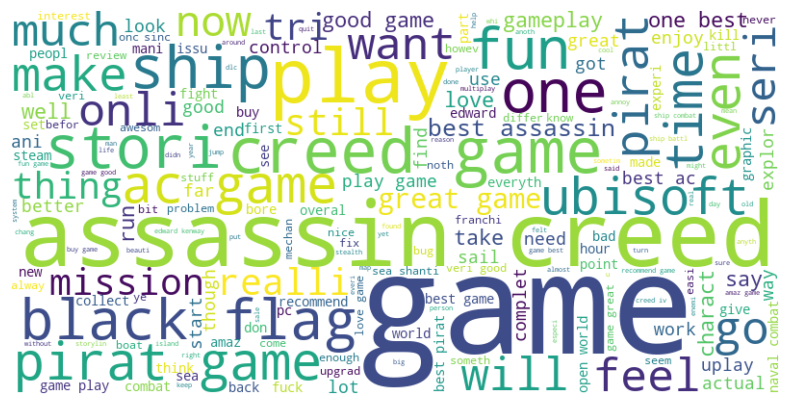

In [138]:
all_sentences = ' '.join(clean_reviews['review'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_sentences)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that the words 'assassin creed', 'black flag', and 'game' come up quite often. This is given, considering the topic of the reviews. Let's remove these to get a more accurate representation of what words are more common with no relation to the game.

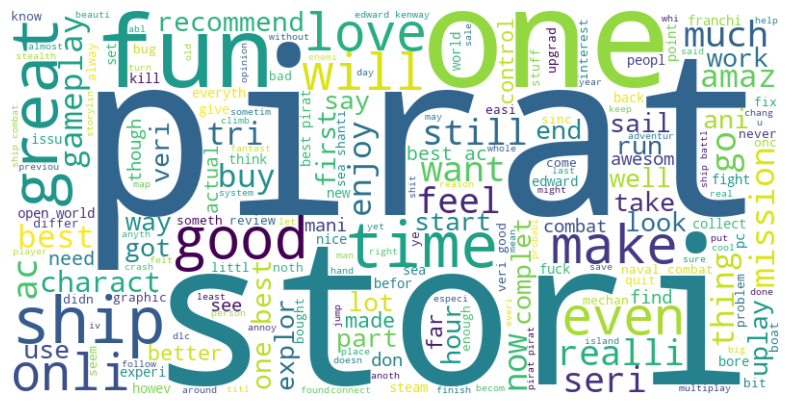

In [88]:
clean_reviews_r2 = stop_stem(clean_reviews, 'review', ["assassin's", 'creed', 'assassin', 'black flag', 'black', 'flag', 'game', 'play', 'ubisoft'])

all_sentences = ' '.join(clean_reviews_r2['review'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_sentences)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

This would be a more accurate representation of more common words. As the nature of the game is a pirate ship game, it would make sense for pirate and ship to be common words. 'stori' (story) seems to be a very common word as well, likely people are either loving or hating the storyline of the game. 

We can see good positive feedback from words like 'great', 'fun', and 'love', so this may be a good indication of what most people feel about the game. However, let's look into the bar chart of the more common words to have a clearer visual of this.

### Bar Graph of Popular Words

In [140]:
corpus = ' '.join(clean_reviews_r2['review'])

# Tokenization
tokens = word_tokenize(corpus)

# Count unique words
word_counts = Counter(tokens)

top_25 = word_counts.most_common(25)

top_25

[('to', 24308),
 ('in', 11850),
 ('pirat', 7544),
 ('on', 6891),
 ('not', 5616),
 ('good', 5381),
 ('ship', 5181),
 ('best', 5115),
 ('stori', 5015),
 ('like', 4944),
 ('one', 4773),
 ('can', 4764),
 ('so', 4512),
 ('all', 4470),
 ('just', 4406),
 ('get', 4186),
 ('ac', 3928),
 ('fun', 3856),
 ('time', 3774),
 ('great', 3640),
 ('from', 3123),
 ('veri', 2977),
 ('realli', 2943),
 ('more', 2761),
 ('some', 2545)]

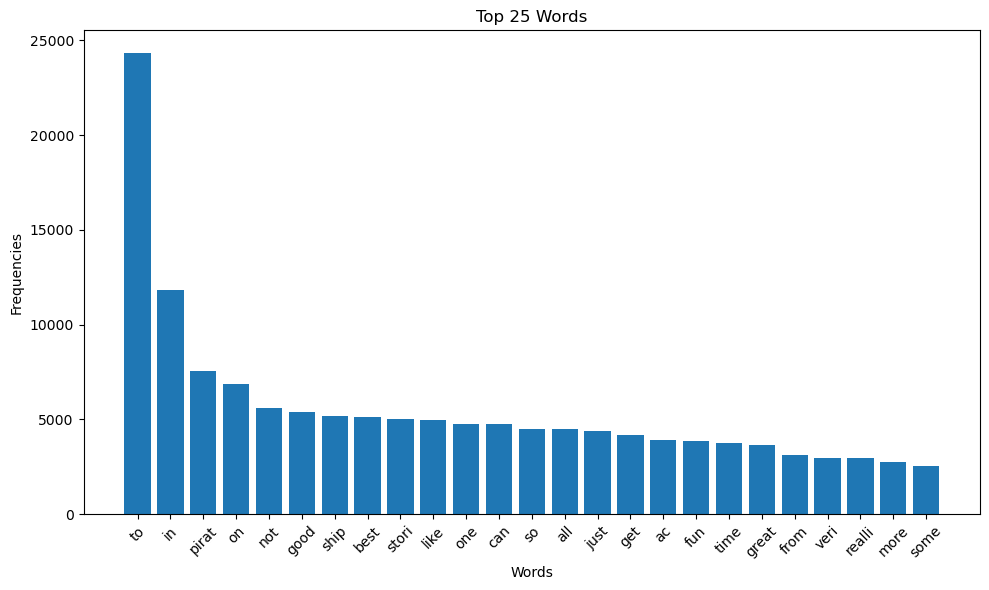

In [141]:
words = [word[0] for word in top_25]
frequencies = [word[1] for word in top_25]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel("Words")
plt.ylabel("Frequencies")
plt.title("Top 25 Words")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

There are still many stop 'useless' stopwords in the reviews according to the top 25 words. Let's do a second round of removal.

In [89]:
clean_reviews_r3 = stop_stem(clean_reviews_r2, 'review', ['to', 'in', 'on', 'can', 'so', 'all', 'just', 'from', 'get'])

corpus = ' '.join(clean_reviews_r3['review'])

# Tokenization
tokens = word_tokenize(corpus)

# Count unique words
word_counts = Counter(tokens)

top_25_r3 = word_counts.most_common(25)

top_25_r3

[('pirat', 7545),
 ('not', 5616),
 ('good', 5381),
 ('ship', 5181),
 ('best', 5115),
 ('stori', 5015),
 ('like', 4944),
 ('one', 4773),
 ('ac', 3928),
 ('fun', 3856),
 ('time', 3774),
 ('great', 3640),
 ('veri', 2977),
 ('realli', 2943),
 ('more', 2761),
 ('some', 2545),
 ('up', 2503),
 ('combat', 2400),
 ('out', 2383),
 ('even', 2365),
 ('love', 2359),
 ('still', 2278),
 ('when', 2265),
 ('will', 2225),
 ('make', 2199)]

Now let's take a look at them without the additional stopwords.

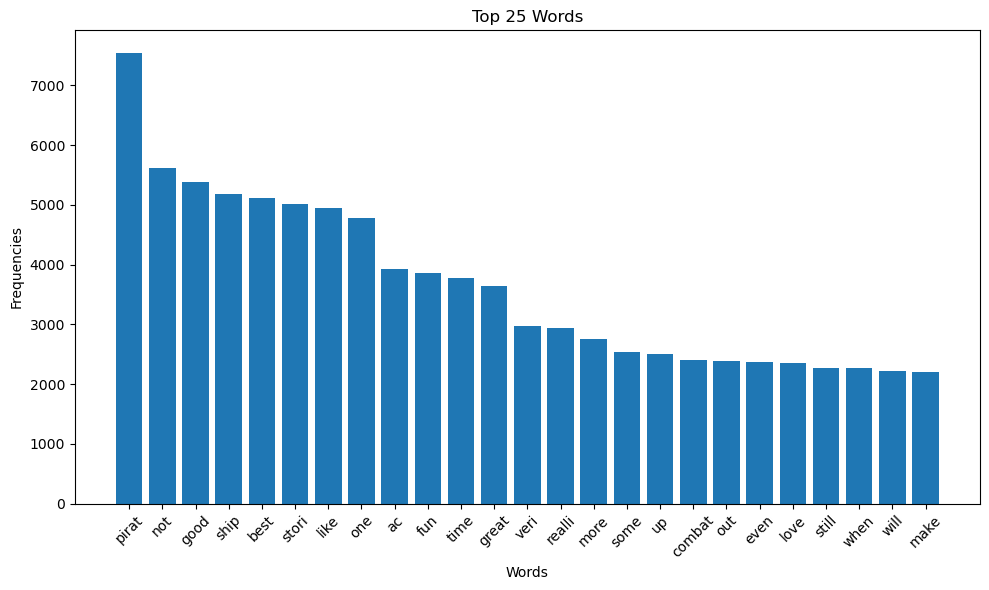

In [90]:
words_r3 = [word[0] for word in top_25_r3]
frequencies_r3 = [word[1] for word in top_25_r3]

plt.figure(figsize=(10, 6))
plt.bar(words_r3, frequencies_r3)
plt.xlabel("Words")
plt.ylabel("Frequencies")
plt.title("Top 25 Words")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The top few words consist of both 'not' and 'good'. There is no guarantee that these two words are usually found together, hence we cannot assume that majority of reviews said the game was 'not good'. Let's check the top 2-gram words to see what the consensus of the game were.

In [91]:
tfid = TfidfVectorizer(ngram_range=(2,2))

ngram_features = tfid.fit_transform(clean_reviews_r3['review'])
ngram_names = tfid.get_feature_names_out()
ngram_df = pd.DataFrame(ngram_features.toarray(), columns = ngram_names)

ngram_frequencies = ngram_df.sum().astype(int)

sorted_ngrams = ngram_frequencies.sort_values(ascending = False)

ngram_25 = sorted_ngrams.head(25)

ngram_25

best ac         273
one best        220
best ever       188
best pirat      172
veri good       157
pirat ever       81
veri fun         77
best seri        74
ac ever          68
sea shanti       68
open world       65
like pirat       64
veri nice        53
ever made        52
realli good      52
good stori       50
pretti good      48
great stori      48
naval combat     45
feel like        45
better than      44
good pirat       42
ship battl       40
best franchi     39
ship combat      38
dtype: int64

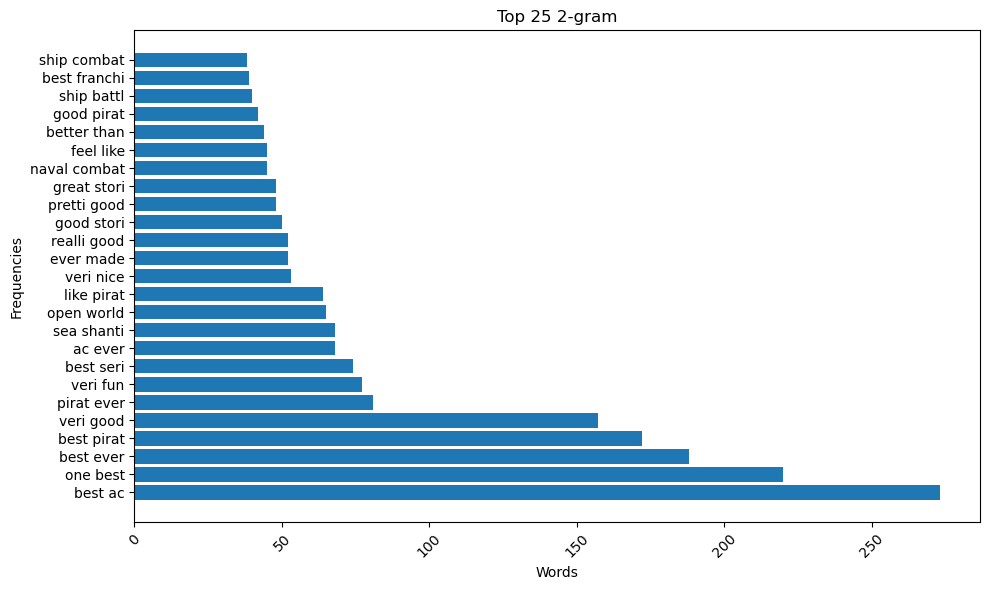

In [92]:
plt.figure(figsize=(10, 6))
plt.barh(ngram_25.index, ngram_25.values)
plt.xlabel("Words")
plt.ylabel("Frequencies")
plt.title("Top 25 2-gram")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Looking through the most common n-gram 2 words, we can see 'best ac' and the words 'best' being part of most of them. ('ac' referring the assassins creed in short). 

It can be safe to say that most people really enjoyed the game, giving good reviews such as the fact that it is one of the best pirate/assassins creed game every, especially liking the story as well. 

So we would wonder, what were people not liking then? Let's find out which n-gram 2 contained 'not' to see what people were dissatisfied about.

In [93]:
keyword = 'not'
filtered_ngrams = []

for ngram in sorted_ngrams.index:
    if keyword in ngram:
        filtered_ngrams.append(ngram)

filtered_ngrams_frequency = {}

for ngram in filtered_ngrams:
    frequency = sorted_ngrams[ngram]
    filtered_ngrams_frequency[ngram] = frequency

filtered_ngrams_df = pd.DataFrame(list(filtered_ngrams_frequency.items()), columns=['Ngram', 'Frequency']).head(25)

print(filtered_ngrams_df)

            Ngram  Frequency
0         not buy         20
1        not best         20
2        not work         18
3        will not         17
4         not bad         16
5        not good         15
6   not recommend         13
7       pirat not         13
8        not much         12
9        not like         12
10       not even         11
11        not too         11
12     not realli         11
13       good not         10
14        one not         10
15       not onli         10
16       best not          8
17        not fan          8
18      not worth          8
19       not veri          8
20      stori not          8
21      would not          7
22        not fun          7
23       not sure          6
24        whi not          6


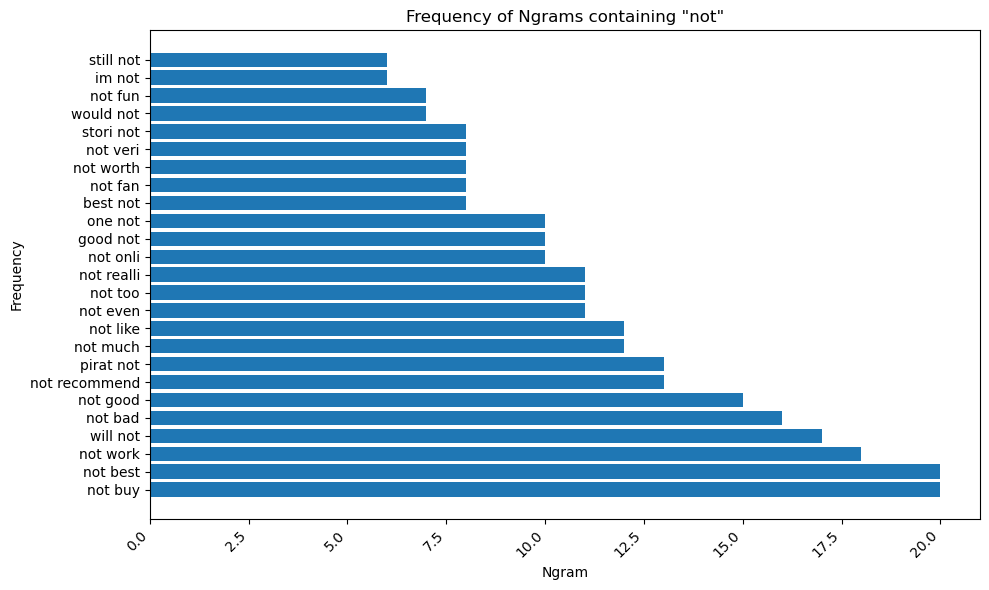

In [94]:
filtered_ngrams_df = pd.DataFrame(list(filtered_ngrams_frequency.items()), columns=['Ngram', 'Frequency'])

# Sort the DataFrame by frequency in descending order
filtered_ngrams_df = filtered_ngrams_df.sort_values(by='Frequency', ascending=False).head(25)

# Plotting
plt.figure(figsize=(10, 6));
plt.barh(filtered_ngrams_df['Ngram'], filtered_ngrams_df['Frequency']);
plt.xlabel('Ngram');
plt.ylabel('Frequency');
plt.title(f'Frequency of Ngrams containing "{keyword}"');
plt.xticks(rotation=45, ha='right');
plt.tight_layout();

plt.show()

We can see that there were a number of people who disliked the game as well, mentioning things such as they would not buy it, or that it's not the best, things not working etc. 

For Ubisoft, this will be good to know, and they can use this in the future to know what to further improve on. 

<a id='modelling'></a>

---
# Modelling
---

As we are trying to focus on word data for this, we will only use the 'review' column as our X value, and our y value will be the recommended column i.e. 'voted_up'.

In [97]:
X = clean_reviews_r3['review']
y = clean_reviews_r3['voted_up']

In [105]:
# Splitting train test split, and stratifying y so we can a better distribution of values.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 123, stratify=y)

In [99]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15362,)
(6585,)
(15362,)
(6585,)


## Naive Bayes

Vectorizing the reviews and using Naive Bayes model to see how it fairs in predictions.

In [106]:
tvec = TfidfVectorizer()

In [107]:
X_train_tvec = tvec.fit_transform(X_train)


In [109]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tvec, y_train)

y_train_pred = nb_classifier.predict(X_train_tvec)
tvec_train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Naive Bayes prediction accuracy = {tvec_train_accuracy}")

Naive Bayes prediction accuracy = 0.89812524410884


In [110]:
def matrix_scores(matrix, name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix of {name}")
    plt.show()

    true_negatives = matrix[0, 0]
    false_positives = matrix[0, 1]
    false_negatives = matrix[1, 0]
    true_positives = matrix[1, 1]

    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    print(f"{name} Recall: {recall}")
    print(f"{name} Specificity: {specificity}")

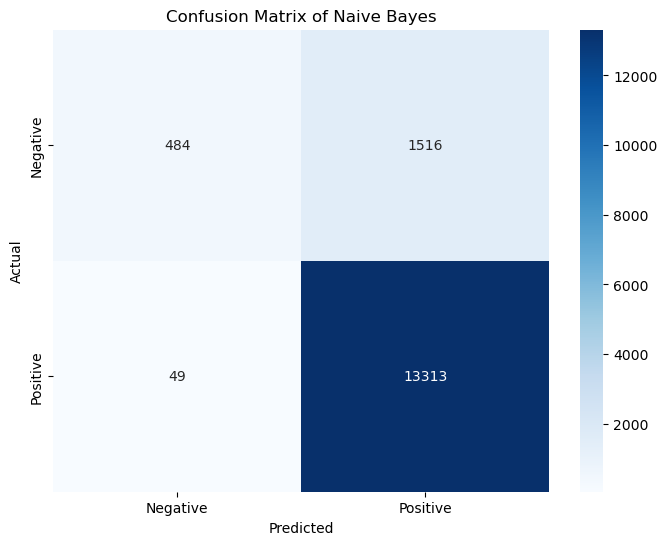

Naive Bayes Recall: 0.9963328842987577
Naive Bayes Specificity: 0.242


In [111]:
conf_matrix = confusion_matrix(y_train, y_train_pred)

matrix_scores(conf_matrix, 'Naive Bayes')

The Naive Bayes did a good job at predicting the true positive comments, however, it didn't do a very good job at predicting the true negative values. Let's see how it does for unseen data.

In [113]:
X_test_tvec = tvec.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_test_tvec, y_test)

y_test_pred = nb_classifier.predict(X_test_tvec)
tvec_test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Naive Bayes Test prediction accuracy = {tvec_test_accuracy}")

Naive Bayes Test prediction accuracy = 0.8735003796507214


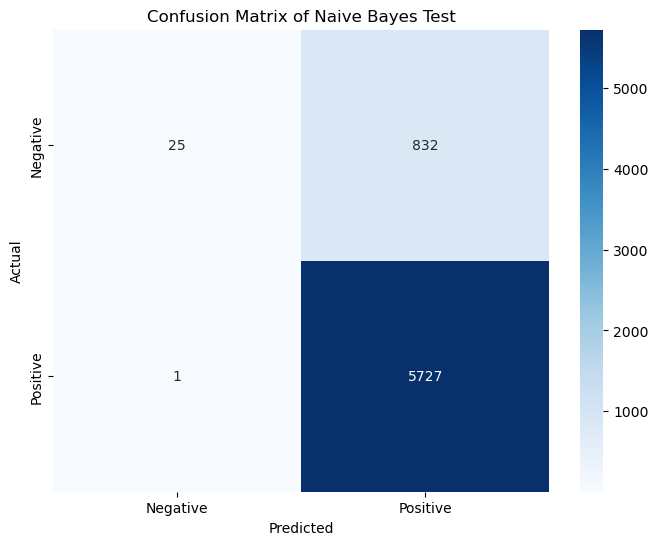

Naive Bayes Test Recall: 0.9998254189944135
Naive Bayes Test Specificity: 0.029171528588098017


In [114]:
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

matrix_scores(conf_matrix_test, 'Naive Bayes Test')

As per the train results, the Naive Bayes test results didn't do a very good job at predicting the positive and negative comments. 

### Naive Bayes 2 n-gram

Let's try to use 2 n-grams to see if the results will improve.

In [123]:
tvecn2 = TfidfVectorizer(ngram_range=(2,2))
X_train_tvecn2 = tvecn2.fit_transform(X_train)


In [124]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tvecn2, y_train)

y_train_predn2 = nb_classifier.predict(X_train_tvecn2)
tvecn2_train_accuracy = accuracy_score(y_train, y_train_predn2)

print(f"Naive Bayes prediction accuracy = {tvecn2_train_accuracy}")

Naive Bayes prediction accuracy = 0.8811352688452024


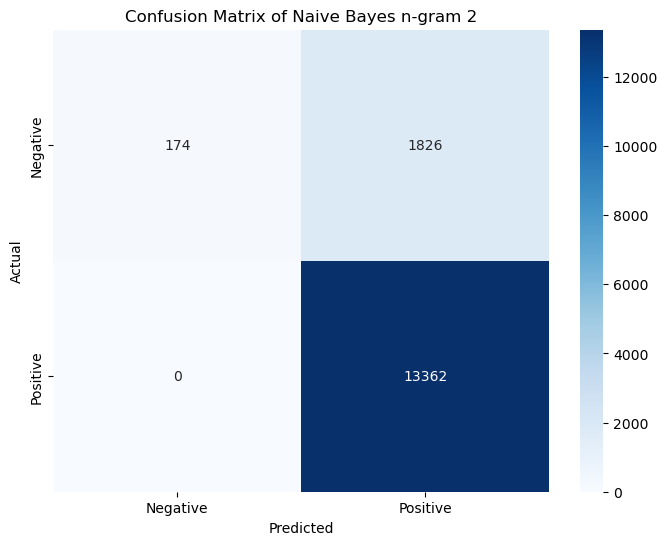

Naive Bayes n-gram 2 Recall: 1.0
Naive Bayes n-gram 2 Specificity: 0.087


In [125]:
conf_matrixn2 = confusion_matrix(y_train, y_train_predn2)

matrix_scores(conf_matrixn2, 'Naive Bayes n-gram 2')

The n-gram 2 Naive Bayes model did a better job at predicting true values, even resulting to 1.0 accuracy. However, it did a worse job at predicting true negative reviews. 

Let's try this again on unseen test data.

In [126]:
X_test_tvecn2 = tvecn2.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_test_tvecn2, y_test)

y_test_predn2 = nb_classifier.predict(X_test_tvecn2)
tvecn2_test_accuracy = accuracy_score(y_test, y_test_predn2)

print(f"Naive Bayes prediction accuracy = {tvecn2_test_accuracy}")

Naive Bayes prediction accuracy = 0.8706150341685649


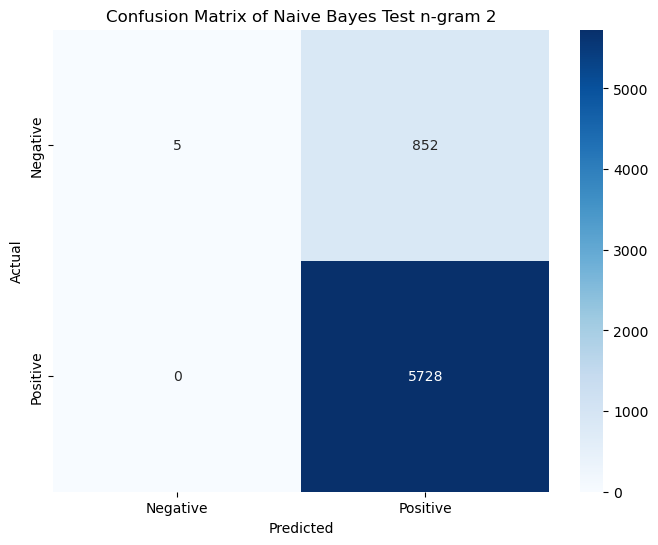

Naive Bayes Test n-gram 2 Recall: 1.0
Naive Bayes Test n-gram 2 Specificity: 0.005834305717619603


In [127]:
conf_matrixn2_test = confusion_matrix(y_test, y_test_predn2)

matrix_scores(conf_matrixn2_test, 'Naive Bayes Test n-gram 2')

The n-gram 2 did even worse at predicting true negative values! 

Although the positive predictions are great, this is not the most accurate model. Let's switch to Random Forest and see if the model can perform better.

## Random Forest

In [129]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tvec, y_train)

y_train_rf_pred = rf_classifier.predict(X_train_tvec)
rf_accuracy = accuracy_score(y_train, y_train_rf_pred)
print(f"Random Forest prediction accuracy = {rf_accuracy}")

Random Forest prediction accuracy = 0.9970706939200625


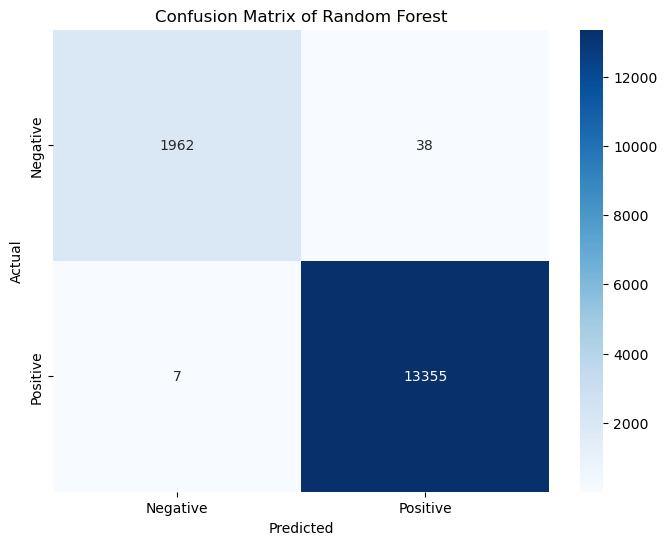

Random Forest Recall: 0.999476126328394
Random Forest Specificity: 0.981


In [130]:
rf_matrix = confusion_matrix(y_train, y_train_rf_pred)

matrix_scores(rf_matrix, 'Random Forest')

The random forest model did so much better than the naive bayes model. We can see there are a lot more accurate true positive and true negative values. Let's try and test this on the unseen test data.

In [131]:
rf_classifier.fit(X_test_tvec, y_test)

y_test_rf_pred = rf_classifier.predict(X_test_tvec)
rf_test_accuracy = accuracy_score(y_test, y_test_rf_pred)
print(f"Random Forest Test prediction accuracy = {rf_test_accuracy}")

Random Forest Test prediction accuracy = 0.996962794229309


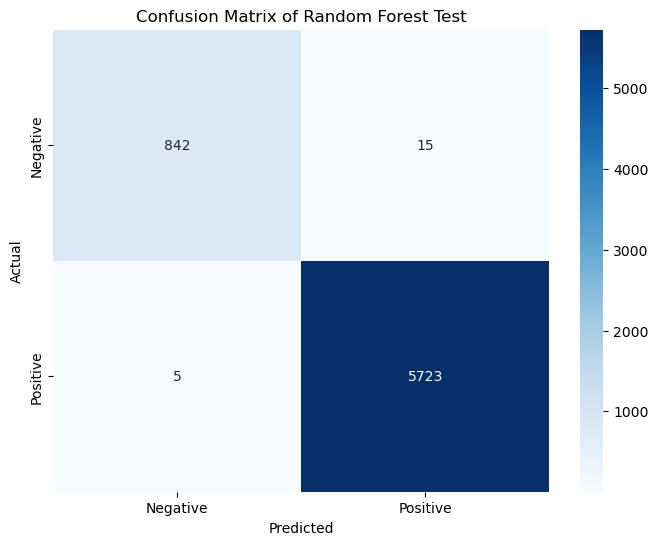

Random Forest Test Recall: 0.9991270949720671
Random Forest Test Specificity: 0.9824970828471412


In [132]:
rf_test_matrix = confusion_matrix(y_test, y_test_rf_pred)

matrix_scores(rf_test_matrix, 'Random Forest Test')

The random forest model performs very well, with less than 0.02 accuracy difference. This is a huge improvement from the previous Naive Bayes model.

Now, let's try and vectorize this with n-gram 2.

In [133]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tvecn2, y_train)

y_train_rfn2_pred = rf_classifier.predict(X_train_tvecn2)
rfn2_accuracy = accuracy_score(y_train, y_train_rfn2_pred)
print(f"Random Forest prediction accuracy = {rfn2_accuracy}")

Random Forest prediction accuracy = 0.9938810050774639


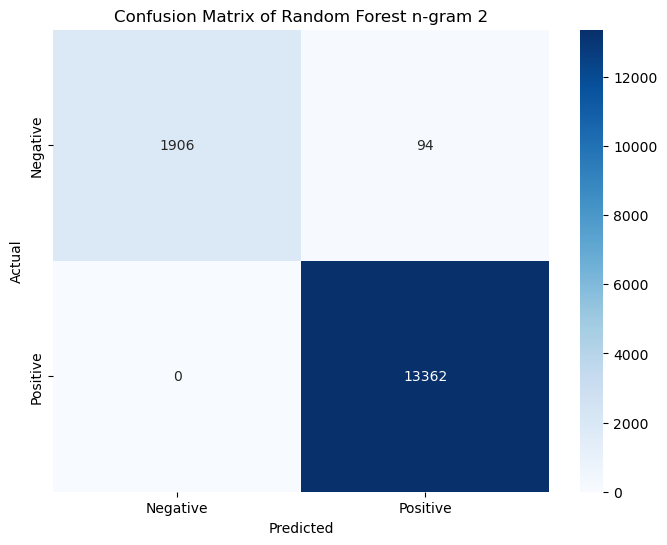

Random Forest n-gram 2 Recall: 1.0
Random Forest n-gram 2 Specificity: 0.953


In [134]:
rfn2_matrix = confusion_matrix(y_train, y_train_rfn2_pred)

matrix_scores(rfn2_matrix, 'Random Forest n-gram 2')

The random forest model gave a perfect prediction of positive reviews, but did slightly worse with the true negative reviews. It was not bad, but it was not as good as the previous Random Forest model

But let's see how this model fairs with the test data.

In [136]:
rf_classifier.fit(X_test_tvecn2, y_test)

y_test_rfn2_pred = rf_classifier.predict(X_test_tvecn2)
rfn2_test_accuracy = accuracy_score(y_test, y_test_rfn2_pred)
print(f"Random Forest Test prediction accuracy = {rfn2_test_accuracy}")

Random Forest Test prediction accuracy = 0.9908883826879271


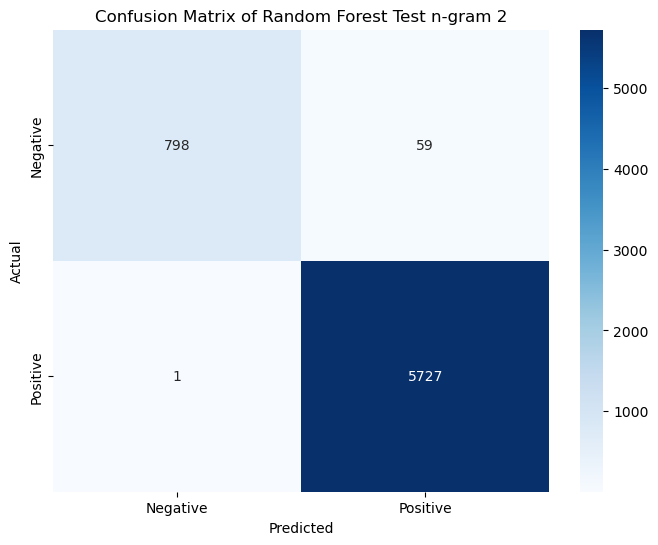

Random Forest Test n-gram 2 Recall: 0.9998254189944135
Random Forest Test n-gram 2 Specificity: 0.9311551925320887


In [137]:
rfn2_test_matrix = confusion_matrix(y_test, y_test_rfn2_pred)

matrix_scores(rfn2_test_matrix, 'Random Forest Test n-gram 2')

Similar to the train data, the random forest with n-gram 2 did better at predicting true positive, but slightly less with the true negative.

### Evaluation 

| Type                               | Train Accuracy | Test Accuracy |
|------------------------------------|----------------|---------------|
| Naive Bayes Recall                 | 0.996          | 0.999         |
| Naive Bayes Specificity            | 0.242          | 0.029         |
| Naive Bayes n-gram 2 Recall        | 1.000          | 1.000         |
| Naive Bayes n-gram 2 Specificity   | 0.087          | 0.006         |
| Random Forest Recall               | 0.999          | 0.991         |
| Random Forest Specificity          | 0.981          | 0.982         |
| Random Forest n-gram 2 Recall      | 1.000          | 0.999         |
| Random Forest n-gram 2 Specificity | 0.953          | 0.931         |

With the results of all the models, we want a good balance between the recall and specificity as these are the best ways to truly identify the true positive and negative reviews. 

As such, to balance between the two scores, we would recommend to go with the normal Random Forest model, without the n-gram 2. This is to minimise the errors for both positive and negative reviews.

<a id='conc_rec'></a>

---
# Conclusions and Recommendations
---

As part of Ubisoft's data team, we were able to produce a 99% accurate model to predict the positive and negative reviews from Steam. This is using the Random Forest model. 

The model, although performs very well, can always be improved. Other areas to try could be to increase the features to see if this gives an ever more accurate result.

Ubisoft's Assassin's Creed IV: Black Flag had received an overwhelming number of positive reviews and recommendations, and the model developed was able to filter through these reviews to classify them as positive and negative in a successful manner. 

This will help Ubisoft in the future endavours to identify what users liked and what to improve on, for both their current Assassin's Creed IV: Black Flag game, as well as their development of Skull & Bones.